In [30]:
import pandas as pd
from google_play_scraper import Sort, reviews_all

package_name = 'capital.scalable.droid'

lang_country_pairs = [
    ('en', 'de'),  # English (Germany store)
    ('de', 'de'),  # German (Germany store)
]

all_reviews = []

for lang, country in lang_country_pairs:
    print(f"Scraping {lang}-{country} ...")
    try:
        reviews = reviews_all(
            package_name,
            sleep_milliseconds=0,
            lang=lang,
            country=country,
            sort=Sort.NEWEST,
            count=400
        )
        for r in reviews:
            r['lang'] = lang
            r['country'] = country
        all_reviews.extend(reviews)
    except Exception as e:
        print(f"Error for {lang}-{country}: {e}")

# Convert the entire collected list to a DataFrame
df = pd.json_normalize(all_reviews)

# Quick sanity check
print(f"Total reviews scraped: {len(df)}")
print(f"Languages found: {df['lang'].value_counts().to_dict()}")
print(df[df["lang"] == "en"].head(5)[["userName", "score", "content", "lang", "country"]])

Scraping en-de ...
Scraping de-de ...
Total reviews scraped: 6909
Languages found: {'de': 5975, 'en': 934}
                userName  score  \
0              Sebastian      1   
1  Masoud Aghebat Andish      1   
2         Saurabh Bansal      1   
3           Atharv Patil      1   
4            Aju Abraham      1   

                                             content lang country  
0  Seit einiger Zeit geht gar nichts mehr. Alle S...   en      de  
1  horrible platform, nothing works and no one's ...   en      de  
2  Troubles logging in. Some mornings the loading...   en      de  
3                     cannot login not receiving otp   en      de  
4  The app has worsened over the period. I have b...   en      de  


In [31]:
# Export to Excel
df.to_excel("ScalableCapitalReviews.xlsx", index=False)

print(f"Scraped {len(df)} reviews and saved to ScalableCapitalReviews.xlsx")

Scraped 6909 reviews and saved to ScalableCapitalReviews.xlsx


In [46]:
import pandas as pd
import re
from deep_translator import GoogleTranslator
from bertopic import BERTopic
from tqdm import tqdm
from collections import Counter

# Optional: Preprocessing helpers
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
tqdm.pandas()

# Filter low-star reviews
df_low = df[df['score'] <= 3].copy()

# Translate German to English
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text

df_low['translated_review'] = df_low['content'].progress_apply(translate_to_english)

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    text = " ".join([w for w in text.split() if w not in stop_words and len(w) > 2])
    return text

df_low['cleaned_review'] = df_low['translated_review'].apply(clean_text)
df_low = df_low[df_low['cleaned_review'].str.len() > 10]  # remove empty/short

# Run BERTopic with tuning
print("Running BERTopic with tuned parameters...")
topic_model = BERTopic(
    language="english",
    min_topic_size=10,    # minimum reviews to form a topic
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(df_low['cleaned_review'])
df_low['topic'] = topics


100%|██████████████████████████████████████████████████████████████████████████████| 3507/3507 [40:27<00:00,  1.44it/s]
2025-10-12 13:13:04,288 - BERTopic - Embedding - Transforming documents to embeddings.


Running BERTopic with tuned parameters...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 109/109 [01:11<00:00,  1.51it/s]
2025-10-12 13:14:19,350 - BERTopic - Embedding - Completed ✓
2025-10-12 13:14:19,352 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-12 13:15:10,626 - BERTopic - Dimensionality - Completed ✓
2025-10-12 13:15:10,640 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-12 13:15:12,061 - BERTopic - Cluster - Completed ✓
2025-10-12 13:15:12,115 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-12 13:15:12,540 - BERTopic - Representation - Completed ✓


In [47]:
# Get top complaint topics
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info['Topic'] != -1]  # remove outliers (-1)
top_topics = topic_info.sort_values(by='Count', ascending=False).head(10)
print("\n Top complaint topics:")
print(top_topics[['Topic', 'Count', 'Name']])


 Top complaint topics:
    Topic  Count                                    Name
1       0    203        0_fingerprint_pin_password_login
2       1     84               1_trading_sell_market_app
3       2     73          2_login_denied_update_possible
4       3     72         3_watchlist_overview_would_nice
5       4     63             4_savings_plans_plan_direct
6       5     56      5_portfolio_displayed_value_longer
7       6     54  6_postident_account_verification_still
8       7     53          7_black_screen_logging_screens
9       8     53          8_bank_baader_account_transfer
10      9     53        9_service_customer_chat_response


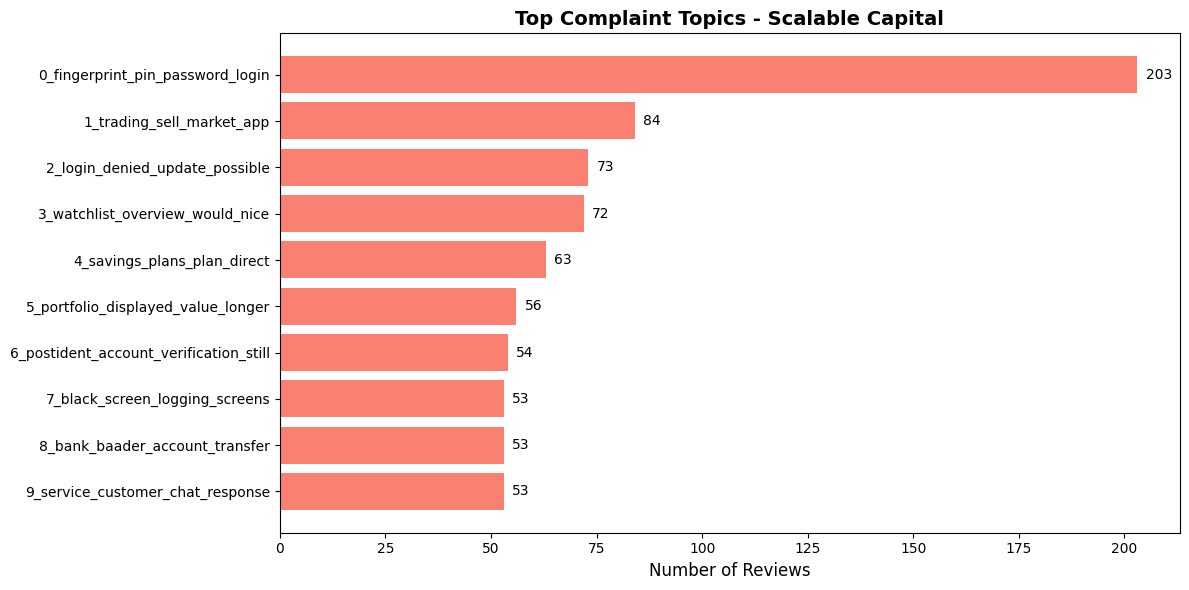

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(12, 6))
bars = plt.barh(top_topics['Name'], top_topics['Count'], color='salmon')
plt.gca().invert_yaxis()  # Highest count on top

plt.title('Top Complaint Topics - Scalable Capital', fontsize=14, weight='bold')
plt.xlabel('Number of Reviews', fontsize=12)
plt.tight_layout()

# Add count labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2,                # x-position slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,  # vertically centered
             str(int(width)),          # label text
             va='center', ha='left', fontsize=10)

plt.show()